In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sjoert.stellar
import pandas as pd
import os
from tqdm import tqdm
from astropy import coordinates as coord
from scipy.optimize import curve_fit
import forced_phot as fp #import flux_jy, chi2, gaussian, chi2_peak_finder
from scipy.constants import h,c,k
import json
from numpyencoder import NumpyEncoder #by Hunter M. Allen (https://pypi.org/project/numpyencoder/)


In [2]:
param_path = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\params.txt'


In [18]:
param_df = pd.read_csv(param_path, sep=",")
columns_old = list(param_df.keys())
columns_new = [c.strip() for c in columns_old]
columns_new[0] = 'ZTF_ID'
column_dict = dict(zip(columns_old,columns_new))
param_df.rename(columns=column_dict,inplace=True)
print(param_df.shape)
# param_array = param_df.to_numpy().T #every row is a parameter

#filtering bad errors and bad chi2/dof values
sigma_rise = param_df['sigma_rise'].to_numpy()
tau_dec = param_df['tau_dec'].to_numpy()

sigma_rise_err = param_df['sigma_rise_err'].to_numpy()
# bad_sigma_error_mask = sigma_rise_err < 1.5 * sigma_rise #if the error is more than 500% of the value let's filter it out bc it's indicative of bad fit
# bad_tau_error_mask = sigma_rise_err <  1.5 * tau_dec #if the error is more than 500% of the value let's filter it out bc it's indicative of bad fit
# # bad_chi2_mask = param_df['chi2_dof'].to_numpy() < 50
bad_log10sigma_error_mask = param_df['log10_sigma_rise_err'] < 0.2 #if the error is more than 500% of the value let's filter it out bc it's indicative of bad fit
bad_log10tau_error_mask = param_df['log10_tau_dec_err'] <  0.2

param_df = param_df[bad_log10sigma_error_mask * bad_log10tau_error_mask]
print(param_df.shape)

(13562, 27)
(9791, 27)


In [19]:
Fp = param_df['F_p'].to_numpy()
F0g = param_df['F_0g'].to_numpy()
F0r = param_df['F_0r'].to_numpy()
green_peaks = Fp - F0g
red_peaks = Fp - F0r
param_df['peak_g'] = green_peaks
param_df['peak_r'] = red_peaks

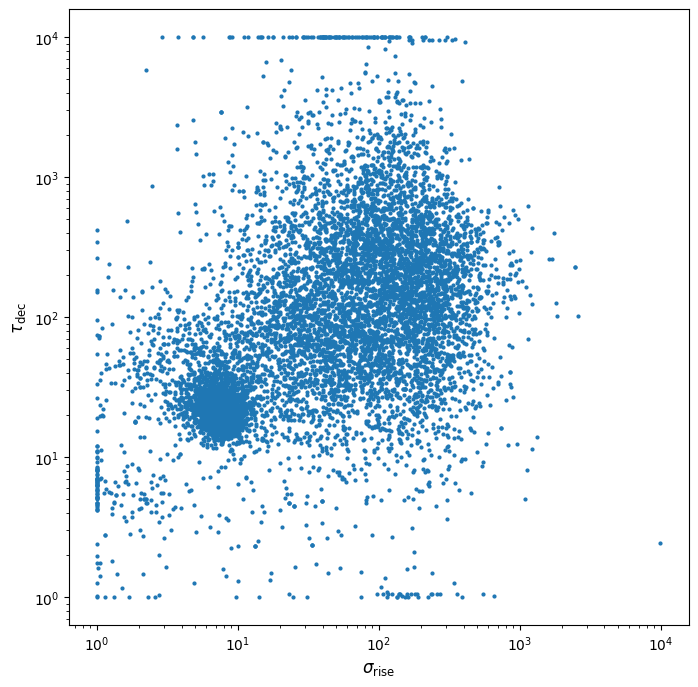

In [20]:
param_label_dict = {'sigma_rise':r'$\sigma_{\text{rise}}$','tau_dec':r'$\tau_{\text{dec}}$',
                    'log10_sigma_rise':r'$\sigma_{\text{rise}}$','log10_tau_dec':r'$\tau_{\text{dec}}$',
                    'F_p':r'F$_{\text{peak}}$','peak_g':r'F$_{\text{p,g}}$','peak_r':r'F$_{\text{p,r}}$'}

def param_scatterplot(param1: str,param2: str,logspace=True):
    param1data = param_df[param1].to_numpy()
    param2data = param_df[param2].to_numpy()

    try:
        #if the parameter has an error (which most always the case for relevant parameters) get that as well
        if logspace:
            param1data_err = param_df['log10_'+param2+'_err']
        else:
            param1data_err = param_df[+param2+'_err']
            # param1data_err = 1/np.log(10) * param_df[param1+'_err'] / param1data
        param1errFlag = True
    except KeyError:
        param1errFlag = False

    try:
        #if the parameter has an error (which most always the case for relevant parameters) get that as well
        if logspace:
            param2data_err = param_df['log10_'+param2+'_err']
        else:
            param2data_err = param_df['log10_'+param2+'_err']
        # param2data_err = 1/np.log(10) * param_df[param2+'_err'] / param2data
        param2errFlag = True
    except KeyError:
        param2errFlag = False

    param1errFlag = False
    param2errFlag = False
    fig,ax = plt.subplots(figsize=(8,8))
    if param1errFlag:
        if param2errFlag:
            ax.errorbar(param1data,param2data,xerr=param1data_err,yerr=param2data_err,fmt=',',capsize=2)
        else:
            ax.errorbar(param1data,param2data,xerr=param1data_err,fmt='.',capsize=2)
    else:
        if param2errFlag:
            ax.errorbar(param1data,param2data,yerr=param2data_err,fmt='.',capsize=2)
        else:
            ax.scatter(param1data,param2data,s=4)
    ax.set_xlabel(param_label_dict[param1],fontsize=12)
    ax.set_ylabel(param_label_dict[param2],fontsize=12)
    #plt.savefig(param1+'_vs_'+param2+'.png',dpi=600)
    ax.set(xscale="log",yscale='log')
    plt.show()

param_scatterplot('sigma_rise','tau_dec')





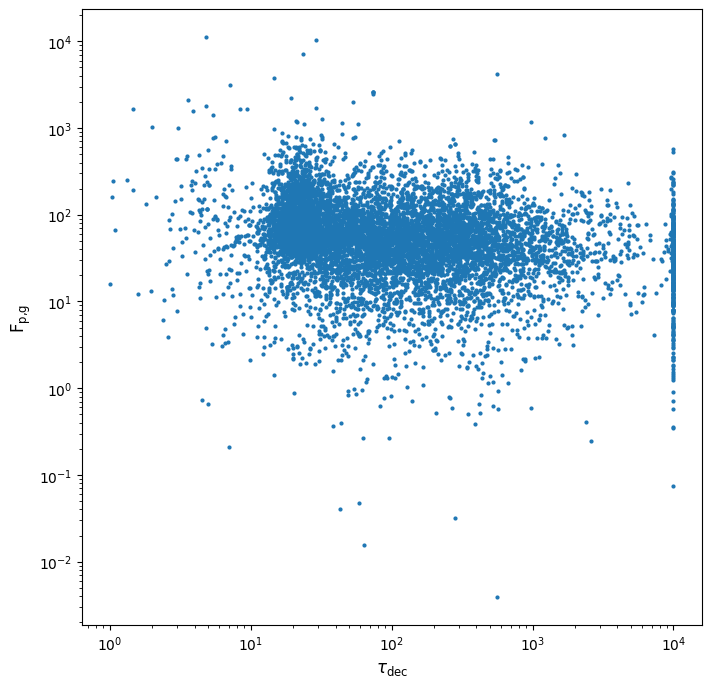

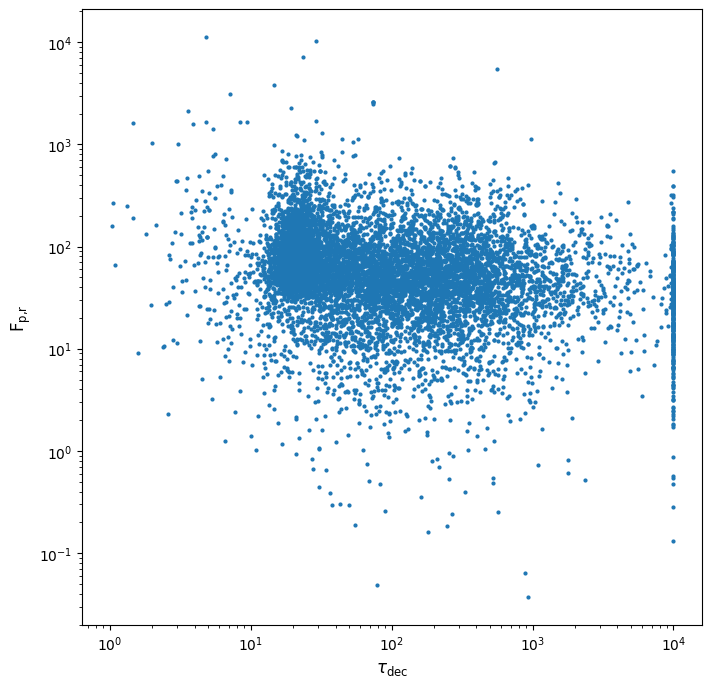

In [6]:
param_scatterplot('tau_dec','peak_g')
param_scatterplot('tau_dec','peak_r')

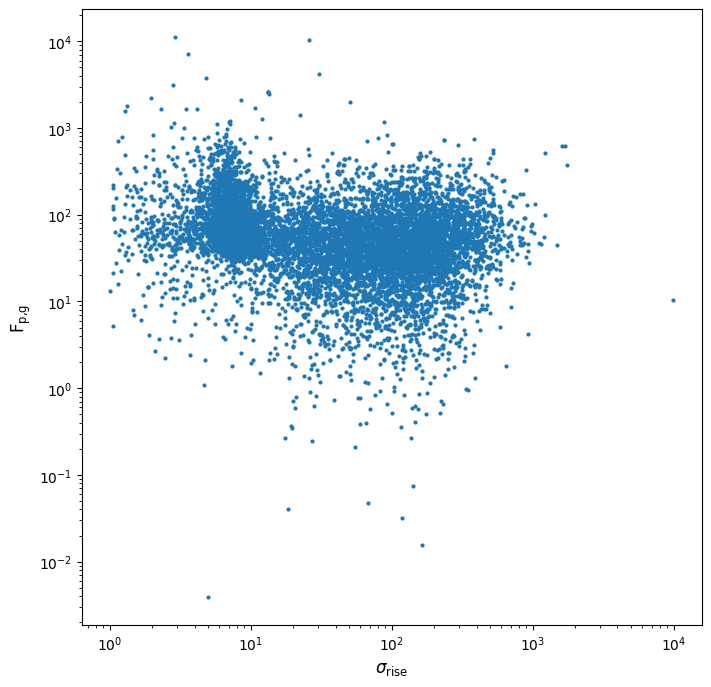

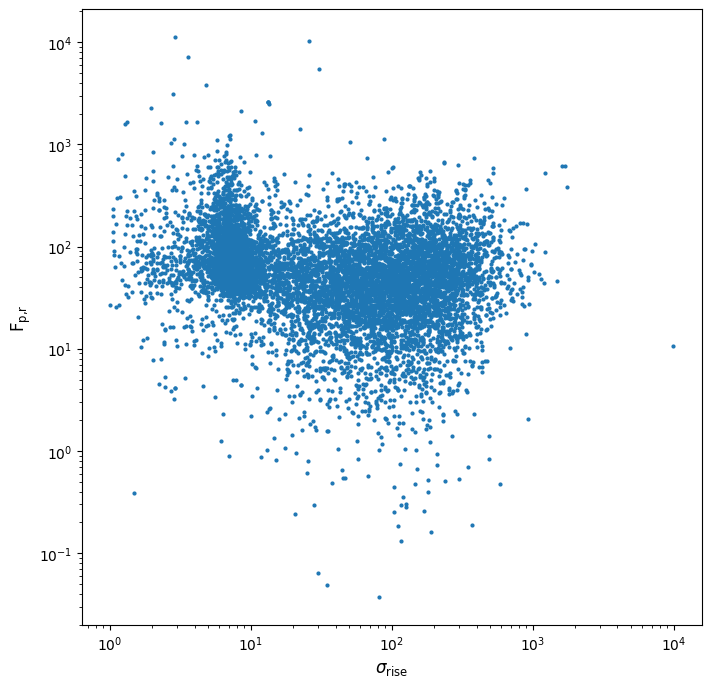

In [7]:
param_scatterplot('sigma_rise','peak_g')
param_scatterplot('sigma_rise','peak_r')

In [21]:
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
X = np.array(list(zip(param_df['sigma_rise'],param_df['tau_dec'])))
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(X)
kmedoid = KMedoids(n_clusters=3,random_state=42).fit(X)



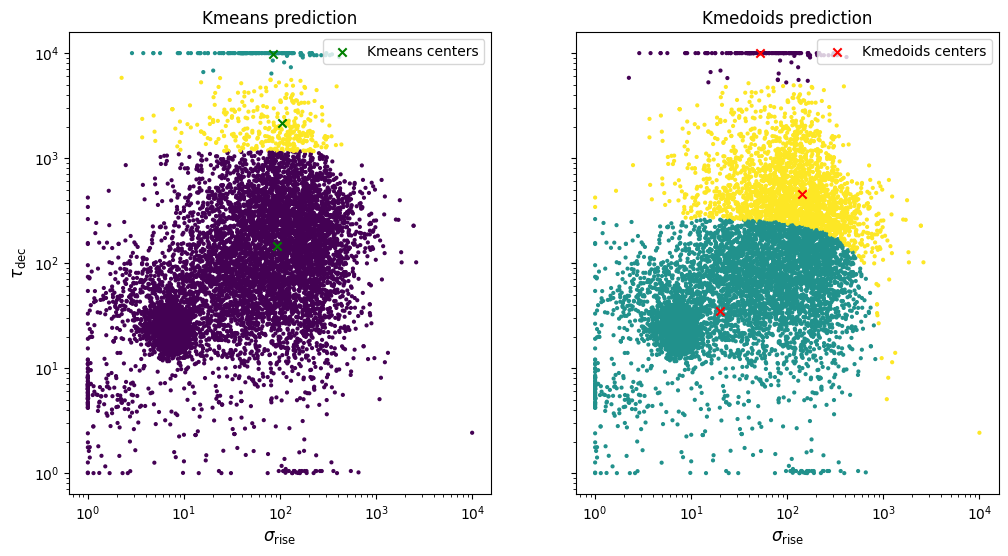

In [22]:
param1errFlag = False
param2errFlag = False
fig,(ax1,ax2) = plt.subplots(figsize=(12,6),ncols=2,sharey=True)
ax1.set_title("Kmeans prediction")
ax2.set_title("Kmedoids prediction")
ax1.scatter(param_df['sigma_rise'],param_df['tau_dec'],s=4,c=kmeans.predict(X))
ax2.scatter(param_df['sigma_rise'],param_df['tau_dec'],s=4,c=kmedoid.predict(X))
ax1.set_xlabel(param_label_dict['sigma_rise'],fontsize=12,)
ax2.set_xlabel(param_label_dict['sigma_rise'],fontsize=12,)
ax1.set_ylabel(param_label_dict['tau_dec'],fontsize=12)
#plt.savefig(param1+'_vs_'+param2+'.png',dpi=600)
ax1.set(xscale="log",yscale='log')
ax2.set(xscale="log",yscale='log')
ax1.scatter(*list(zip(*kmeans.cluster_centers_)),label='Kmeans centers',marker='x',c='green',zorder=10)
ax2.scatter(*list(zip(*kmedoid.cluster_centers_)),label='Kmedoids centers',marker='x',c='red',zorder=10)
ax1.legend()
ax2.legend()
plt.show()

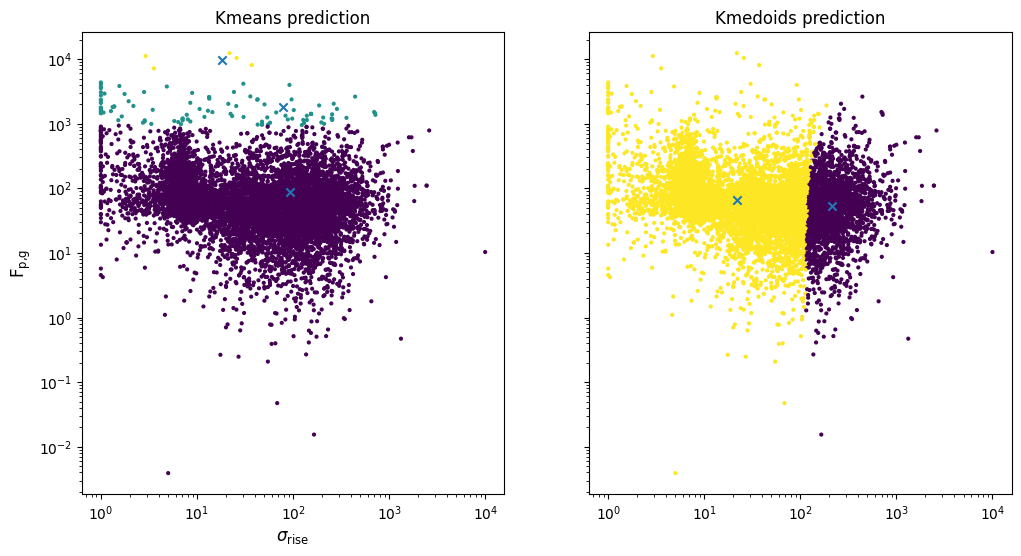

In [23]:
X = np.array(list(zip(param_df['sigma_rise'],param_df['peak_g'])))
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(X)
kmedoid = KMedoids(n_clusters=2,random_state=42).fit(X)

param1errFlag = False
param2errFlag = False
fig,(ax1,ax2) = plt.subplots(figsize=(12,6),ncols=2,sharey=True)
ax1.set_title("Kmeans prediction")
ax2.set_title("Kmedoids prediction")
ax1.scatter(param_df['sigma_rise'],param_df['peak_g'],s=4,c=kmeans.predict(X))
ax2.scatter(param_df['sigma_rise'],param_df['peak_g'],s=4,c=kmedoid.predict(X))
ax1.set_xlabel(param_label_dict['sigma_rise'],fontsize=12,)
ax1.set_ylabel(param_label_dict['peak_g'],fontsize=12)

ax1.set(xscale="log",yscale='log')
ax2.set(xscale="log",yscale='log')
ax1.scatter(*list(zip(*kmeans.cluster_centers_)),label='Kmeans centers',marker='x')
ax2.scatter(*list(zip(*kmedoid.cluster_centers_)),label='Kmedoids centers',marker='x')

plt.show()

In [ ]:
# # ztf_name = 
# clean_data = pd.read_csv(os.path.join(ztf_dir,f"{ztf_name}_clean_data.txt"),
#                                  sep='\t',comment='#',
#                                  names=['time','flux','flux_unc','zeropoint','filter'])
# clean_data.sort_values('time',inplace=True) #sort the data by time for plotting reasons later on
# no_i_mask = clean_data['filter'] != 'ZTF_i' #create the ZTf_i mask to filter out ZTF-i-band data.
# flux,err = fp.flux_jy(clean_data) #convert the flux and its errors to uJY
# err = np.clip(err,0.01*flux,np.inf) # clip the errors to be at least 1% of the flux
# clean_data['flux'] = flux.values #overwrite with new data
# clean_data['flux_unc'] = err.values 